In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


n_noise_vars_list = [0, 1, 5, 10, 50, 100, 200]
n_iterations=500

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('real_estate.csv')
X = data.drop(['No', 'Y house price of unit area'], axis=1)
y = data['Y house price of unit area']
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [3]:
data.shape

(414, 8)

In [4]:
def add_noise_and_rebuild_model(X, y, n_noise_vars):
    """
    Adds n_noise_vars random noise variables to X, rebuilds the linear regression model,
    and calculates R^2 and adjusted R^2.
    """
    # Add noise variables
    for i in range(n_noise_vars):
        X[f'noise_{i}'] = np.random.rand(X.shape[0])
    
    y_pred_with_noise = LinearRegression().fit(X, y).predict(X)
    
    # Calculate R^2 and adjusted R^2
    r2_with_noise = r2_score(y, y_pred_with_noise)
    n_with_noise = X.shape[0]  # Number of observations
    p_with_noise = X.shape[1]  # Number of features including noise
    adjusted_r2_with_noise = 1 - ((1 - r2_with_noise) * (n_with_noise - 1) / (n_with_noise - p_with_noise - 1))
    
    return r2_with_noise, adjusted_r2_with_noise

def monte_carlo_simulation(X, y, n_noise_vars, n_iterations=10):
    """
    Performs a Monte Carlo simulation by adding n_noise_vars random noise variables to X,
    rebuilding the linear regression model n_iterations times, and calculating the mean
    R^2 and mean adjusted R^2.
    """
    r2_values = []
    adjusted_r2_values = []
    
    for _ in range(n_iterations):
        # Randomly add noise and rebuild the model
        X_modified = X.copy()  # Work on a copy to avoid modifying the original
        r2, adjusted_r2 = add_noise_and_rebuild_model(X_modified, y, n_noise_vars)
        r2_values.append(r2)
        adjusted_r2_values.append(adjusted_r2)
    

    
    return r2_values, adjusted_r2_values

def melt_data(data_numpy, x_name, y_name, coltype):
    df_long = pd.DataFrame(data_numpy).T.melt(var_name=x_name, value_name=y_name)
    df_long[x_name] = df_long[x_name].astype(int) 
    df_long['coltype'] = coltype
    return df_long

def draw_2d(data_numpy, data_numpy2, x_name, y_name, xticks):
    df_long1 = melt_data(data_numpy, x_name, y_name, y_name)
    df_long2 = melt_data(data_numpy2, x_name, y_name, y_name + " adjusted") 

    df_long = pd.concat([df_long1, df_long2])

    plt.figure(figsize=(10, 4))

    # Creating the boxplots
    g = sns.boxplot(x=x_name, y=y_name, data=df_long, hue='coltype', palette='Set2')

    # Adding the line through means
    means1 = df_long1.groupby(x_name)[y_name].mean().reset_index()
    means2 = df_long2.groupby(x_name)[y_name].mean().reset_index()
    sns.lineplot(x=x_name, y=y_name, data=means1, color=sns.color_palette('Set2')[0], marker='o', linestyle='-', lw=2)
    sns.lineplot(x=x_name, y=y_name, data=means2, color=sns.color_palette('Set2')[1], marker='o', linestyle='-', lw=2)

    # Finalizing the plot
    plt.title(f'Distribution of {y_name} for different `{x_name}`.')
    g.set_xticklabels(xticks)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid(True)
    plt.show()

In [5]:
# Initialize results list for the Monte Carlo simulation
monte_carlo_r2 = []
monte_carlo_adjr2 = []

# Perform the simulation for each specified number of noise variables
for n_noise_vars in n_noise_vars_list:
    r2, adjusted_r2 = monte_carlo_simulation(X, y, n_noise_vars, n_iterations)
    monte_carlo_r2.append(r2)
    monte_carlo_adjr2.append(adjusted_r2)

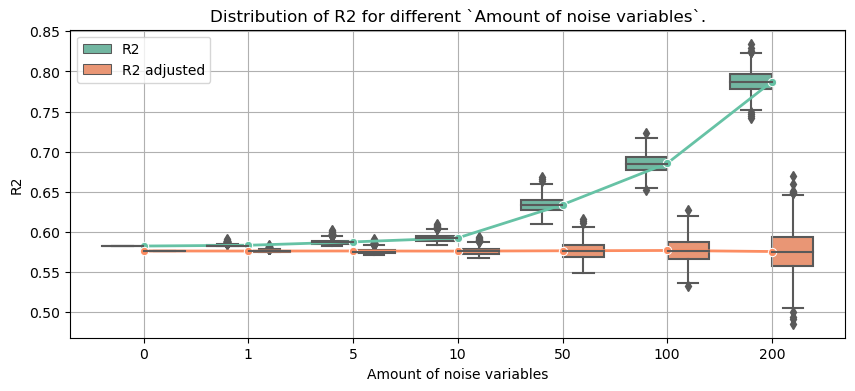

In [6]:
draw_2d(monte_carlo_r2, monte_carlo_adjr2, 'Amount of noise variables', 'R2', n_noise_vars_list)